In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.patches as patch
import scipy as sc
import matplotlib.animation as animation
import os

#%%    Names and adresses / Адреса и имена

Cache_adress = '../golemcache/'
GOLEM_SIGNALS = {'U_RogCoil': 'U_IntRogCoil', 
                  # Plasma current signal / Сигнал с пояса Роговоского
                  'U_loop': 'U_Loop',                  
                  # Loop voltage / Напряжение на обходе
                  'B_t': 'U_IntBtCoil',                
                  # Toroidal magnetic field / Магнитное торполе
                  'MC16': 'ring_',                     
                  # MHD Mirnov coils / МГД магнитные зонды
                  'MC_lim': 'U_mc',                    
                  # Limiter Mirnov coils / Магнитные зонды за лимитером
                  'LP': 'TektrMSO56_LP',               
                  # Langmuir probe / Ленгмюровский зонд
                  'Photodiode': 'U_LeybPhot'           
                  # AXUV / Болометр
                  }

GOLEM_CALIB = {}

In [3]:
#%%    Constants / Константы

R_0    = 40.0              # Major radius [cm] / Большой радиус (см)
r_0    = 10.0              # Minor radius [cm] / Малый радиус (см)
r_lim  = 8.5               # Limiter radius [cm] / Радиус лимитера (см)
r_MC   = 9.3               # Mirnov coils radius [cm] / Радиус расположения магнитных зондов (см)
R_chamber = 9.7E-3         #Chamber resistivity [Ohm] / Сопротивление камеры (Ом)
π = np.pi
μ0 = π*4E-7

# Area of MC16 [cm^2] / Эффективная площадь магнитных зондов набора MC16 (см^2)
# MC16Aeff   = [68.9, 140.7, -138.9, -140.4,
#             68.6, -134.5, 134.3, -142.5,
#             67.6, 142.8, 140.4, 138.0,
#             40.2, 142.2, 139.8, 139.3]      #Thesis of I.Duran
# MC16Aeff   = [68.93, 140.68, -138.83, -140.43,
#               68.59, -134.47, 134.28, -142.46,
#               67.62/1.3, 142.80, 140.43, 140.43,
#               67.62, 140.68, 139.82, 139.33]     #Gomtraic 2013
# Подогонка под матрицу кросс-фаз и ток Роговского
MC16Aeff   = [68.93/1.2, 140.68, -138.83, 140.43,
              68.59, -134.47, 134.28, -142.46,
              67.62/1.8, 142.80, 140.43, 140.43,
              67.62, 140.68, 139.82, 139.33]

z_DRP = 2.5            # Depth of double-rake probe penetration [cm] / Глубина погружения DRP (см)
z_BIAS = 1.0           # Depth of bias-electrode penetration [cm] / Глубина погружения байсинг-электрода (см)

MC16Aeff = np.array(MC16Aeff)*1E-4
MCLimAeff   = [38, 38, 38, 38]       # Area of MCLim [cm^2] / Эффективная площадь магнитных зондов лимитерного набора (см^2)
MCLimAeff = np.array(MCLimAeff)*1E-4
MC16Ang = np.linspace(0.0, 360.0, 17)[0:-1] * π/180.0  # Poloidal angle of MC16 [rad] / Полоидальный угол магнитного зонда из набора MC16 (рад)
MCLim = np.linspace(0.0, 360.0, 5)[0:-1] * π/180.0     # Poloidal angle of MCLim [rad] / Полоидальный угол магнитного зонда из лимитерного набора (рад)

for i in range(len(MC16Aeff)):
    GOLEM_CALIB['ring_'+ str(i+1)] = -1.0/MC16Aeff[i]
    
for i in range(len(MCLim)):
    GOLEM_CALIB['U_mc'+ str(4*i+1)] = -1.0/MCLimAeff[i]

GOLEM_CALIB['U_IntRogCoil'] = -5.3E6 #Rogovskii coil amplifier [A/Vs] / Коэффициент усиления пояса Роговского (А/мВс)
GOLEM_CALIB['TektrMSO56_ALL'] = 1 

In [32]:
#%%    Technical

def read_signal (shot, signal_name, channel = None):
    chan = '' if channel is None else str(channel)
    internal_signal_name = GOLEM_SIGNALS[signal_name]
    internal_signal_name += chan
    calib_coef = GOLEM_CALIB.get(internal_signal_name, 1.0)
    #fname = Cache_adress + str(shot) + '\\' + internal_signal_name + '.csv'
    fname = Cache_adress + str(shot) + '/' + internal_signal_name + '.csv'
    
    #!!! Раньше скачивал сигнал U_Loop, у которого была оцифровка в мс, а не в секундах.
    #Поэтому нужно было домножать на 1000 его время. У сигнала из Tektr'a время правильное,
    #но в заголовке есть лишние строки, поэтому skip_raws.
    if internal_signal_name != 'TektrMSO56_ALL':
        skip_raws = 0
    else:
        skip_raws = 12
    sig = np.loadtxt(fname = fname, dtype = float, comments = '#', delimiter = ',', 
                                usecols = (0,1), skiprows = skip_raws )
    #if (internal_signal_name == 'TektrMSO56_ALL'):
    if sig[-1,0] < 0.5: 
        sig[:,0] *= 1000.0         #Sec to ms / Перевод из сек в мс
    sig[:,1] *= calib_coef          #Signal calibration / Коэффициент усиления
    return sig.T

def pack_sig(t, y):                 #Array of signal [[t], [f]] / Свёртка сигнала в массив [[t], [f]]
    N = len(t)
    result = np.zeros((2, N), np.double)
    result[0, :] = t
    result[1, :] = y
    return result

def resample_as(sig, refsig):   #Resample signal on refsigna l / Общий шаг по времени
    ref_x = refsig[0]
    new_y = np.interp(ref_x, sig[0], sig[1])
    return pack_sig(ref_x, new_y)

def integrate_sig(t, y): #Integrate / Интегрирование
    dt = (t[-1]-t[0])/(len(t)-1)
    return pack_sig(t, np.cumsum(y)*dt)

def calib_sig(t, y, timerange = None): #Zero calibration / Калибровка нуля АЦП
    if timerange is None: 
        timerange = (0.2, 1.4)
    j0 = np.searchsorted(t, timerange[0])
    j1 = np.searchsorted(t, timerange[1])
    if j1 <= j0 or j0 >= len(y) or j1 > len(y):
        zerolevel = 0.0
    else:
        zerolevel = np.mean(y[j0:j1])
    return pack_sig(t, y - zerolevel)

def calib_vac(t, y1, y2):         #Vacuum calibration / Удаление сигнала тороидального магнитного поля
    y = y1 - y2
    return pack_sig (t, y)

def correct_signal(signal_name, shot, vacuum_shot, channel = None):
    Signal_vac = read_signal(vacuum_shot, signal_name, channel)
    Signal = read_signal(shot, signal_name, channel)
    
    Time = read_signal(shot, 'MC16', 1)
    #if signal_name != 'B_t':
    #    Signal = calib_vac(Signal[0], Signal[1], Signal_vac[1])
    #if signal_name == 'U_RogCoil':
    #    Signal = calib_sig(Signal[0], Signal[1], (-0.6, -0.06))
    #elif signal_name == 'MC16':
    #    Signal = calib_sig(Signal[0], Signal[1], (0.2, 1.0))
    #elif signal_name == 'MC_lim':
    #    Signal = calib_sig(Signal[0], Signal[1], (0.2, 1.0))
    Signal = resample_as(Signal, Time)
    return Signal

def x2index(xarray, x): 
    result = np.searchsorted(xarray, x)
    if result < 0: result = 0
    if result >= len(xarray): result = len(xarray)-1
    return result

def extract_trend(signal, begin, end): 
    xx, yy = signal
    t0_0, t0_1 = begin
    t1_0, t1_1 = end
    t0 = 0.5*(t0_0 + t0_1)
    t1 = 0.5*(t1_0 + t1_1)
      
    i0_0, i0_1 = x2index(xx, t0_0), x2index(xx, t0_1)
    i1_0, i1_1 = x2index(xx, t1_0), x2index(xx, t1_1)
    i0 = x2index(xx, t0)
    i1 = x2index(xx, t1)
    
    #y0 = np.mean(yy[i0_0:i0_1])
    #y1 = np.mean(yy[i1_0:i1_1])
    y0 = np.mean(yy[i0_0:i0_1]) if i0_1 > i0_0 else 0.0
    y1 = np.mean(yy[i1_0:i1_1]) if i1_1 > i1_0 else 0.0
            
    result = np.zeros_like(yy)
    result[i0:i1] = np.linspace(y0, y1, i1-i0)
    result[0:i0] = y0
    result[i1:] = y1
    return pack_sig(xx, result)

def calib_slope(signal, begin, end):
    xx, yy = signal
    trend = extract_trend(signal, begin, end)
    yy = yy - trend[1]
    
    return pack_sig(xx, yy)

def plot_interm_res(mset=None):
    if mset in [None, 4]: 
        for i in [1, 2, 3, 4]: plt.plot(MC4L[0], 
            calib_slope(integrate_sig(MC4L[0], MC4L[i]), (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))[1])   
    if mset in [None, 16]: 
        for i in [1, 5, 9, 13]: plt.plot(MC16_array[0], 
            calib_slope(integrate_sig(MC16_array[0], MC16_array[i]), (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))[1])

In [5]:
def calib_sig(t, y, timerange = None): #Zero calibration / Калибровка нуля АЦП
    if timerange is None: 
        timerange = (0.2, 1.4)
    j0 = np.searchsorted(t, timerange[0])
    j1 = np.searchsorted(t, timerange[1])
    if j1 <= j0 or j0 >= len(y) or j1 > len(y):
        zerolevel = 0.0
    else:
        zerolevel = np.mean(y[j0:j1])
    return pack_sig(t, y - zerolevel)

In [6]:
#%%    Plasma current 

def plasma_current(shot, vacuum_shot):
    I_pl = correct_signal('U_RogCoil', shot, vacuum_shot) 
    I_pl[1] = 1E-3*I_pl[1]     #from mV to V
    I_pl = integrate_sig(I_pl[0], I_pl[1])
    U_loop = correct_signal('U_loop', shot, vacuum_shot)
    I_pl[1] = I_pl[1]-U_loop[1]/R_chamber
    return I_pl

In [7]:
#%%    Safety factor calculation

def edge_safety_factor(Δz, Δr, r_pl, I_pl, B_t, t_0, t_1):
    q = 2*π*0.01/μ0*B_t[1]/I_pl[1]*(r_pl[1])**2/(Δr[1] + R_0)
    q = pack_sig(r_pl[0], q)
    return q

In [8]:
#%%    Discharge duration calculation

#!!! Исправить определение t_1 (U_loop, скачок в середине импульса)

def discharge_duration(I_pl, U_loop):
    U_loop_max = np.max(U_loop[1])
    for i in range(len(I_pl[0])-1):
        if I_pl[1, i+1] > 50.0:
            t_0 = I_pl[0, i]
            break
    for i in range(len(I_pl[0])-1):
        if U_loop[1, i] == U_loop_max:
            t_1 = U_loop[0, i]
            break
    return t_0, t_1

In [9]:
#%%    Plasma position calculation

def plasma_position(signal_name, MC):
    if signal_name == 'MC_lim':
        B_1 = calib_slope(integrate_sig(MC[0], MC[1]),
                          (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))
        B_5 = calib_slope(integrate_sig(MC[0], MC[2]),
                          (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))
        B_9 = calib_slope(integrate_sig(MC[0], MC[3]),
                          (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))
        B_13 = calib_slope(integrate_sig(MC[0], MC[4]),
                          (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))
    if signal_name == 'MC16':
        B_1 = calib_slope(integrate_sig(MC[0], MC[1]),
                          (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))
        B_5 = calib_slope(integrate_sig(MC[0], MC[5]),
                          (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))
        B_9 = calib_slope(integrate_sig(MC[0], MC[9]),
                          (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))
        B_13 = calib_slope(integrate_sig(MC[0], MC[13]),
                          (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))    
    Δz   =  r_MC*(B_5[1]-B_13[1])/(B_5[1]+B_13[1])     # cm
    Δr   =  r_MC*(B_1[1]-B_9[1])/(B_1[1]+B_9[1])       # cm
    r_pl = r_lim - (Δz**2 + Δr**2)**(0.5)  # cm
    r_pl[np.abs(r_pl) > 2*r_lim] = 0.0
    r_pl[r_pl < 0.0] = 0.0
    
    Δz   = pack_sig(MC[0], Δz)
    Δr   = pack_sig(MC[0], Δr)
    r_pl = pack_sig(MC[0], r_pl)
    
    return Δz, Δr, r_pl

In [10]:
#%%    Mirnov coils signals download

def MC_array(signal_name, shot, vacuum_shot):
    
    if signal_name == 'MC_lim':
        MC1 = correct_signal(signal_name, shot, vacuum_shot, channel = 1)
        MC5 = correct_signal(signal_name, shot, vacuum_shot, channel = 5)
        MC9 = correct_signal(signal_name, shot, vacuum_shot, channel = 9)
        MC13 = correct_signal(signal_name, shot, vacuum_shot, channel = 13)
        MC_array = np.vstack( (MC1[0], MC1[1], MC5[1], MC9[1], MC13[1]) )
        
    if signal_name == 'MC16': 
        MC1 = correct_signal(signal_name, shot, vacuum_shot, channel = 1)
        MC2 = correct_signal(signal_name, shot, vacuum_shot, channel = 2)
        MC3 = correct_signal(signal_name, shot, vacuum_shot, channel = 3)
        MC4 = correct_signal(signal_name, shot, vacuum_shot, channel = 4)
        MC5 = correct_signal(signal_name, shot, vacuum_shot, channel = 5)
        MC6 = correct_signal(signal_name, shot, vacuum_shot, channel = 6)
        MC7 = correct_signal(signal_name, shot, vacuum_shot, channel = 7)
        MC8 = correct_signal(signal_name, shot, vacuum_shot, channel = 8)
        MC9 = correct_signal(signal_name, shot, vacuum_shot, channel = 9)
        MC10 = correct_signal(signal_name, shot, vacuum_shot, channel = 10)
        MC11 = correct_signal(signal_name, shot, vacuum_shot, channel = 11)
        MC12 = correct_signal(signal_name, shot, vacuum_shot, channel = 12)
        MC13 = correct_signal(signal_name, shot, vacuum_shot, channel = 13)
        MC14 = correct_signal(signal_name, shot, vacuum_shot, channel = 14)
        MC15 = correct_signal(signal_name, shot, vacuum_shot, channel = 15)
        MC16 = correct_signal(signal_name, shot, vacuum_shot, channel = 16)
        MC_array = np.vstack( (MC1[0], MC1[1], MC2[1], MC3[1], MC4[1], MC5[1],
                                MC6[1], MC7[1], MC8[1], MC9[1], MC10[1], MC11[1],
                                MC12[1], MC13[1], MC14[1], MC15[1], MC16[1]))
    return MC_array

In [11]:
#%%    loop Voltage, Current drive and Toroidal magnetic field plotter  

def plot_VCT():
    fig1, ax1 = plt.subplots()
    fig1.subplots_adjust(left=0.1, right=0.75, top=0.95, bottom=0.1)
    ax1.set_xlabel('time, ms')
    ax1.set_xlim(t_0 - 1, t_1 + 1)
    ax1.set_ylabel('Loop voltage, V', color = 'green') 
    ax1.plot(U_loop[0], U_loop[1], label='Loop voltage, V', color = 'green')
    ax1.set_ylim(0, np.max(U_loop[1]))
    ax2 = ax1.twinx()
    ax2.offset=(60, 0)
    ax2.set_ylabel('Current, kA', color = 'red') 
    I_pl_rog, = ax2.plot(I_pl[0], I_pl[1]/1000, label='Plasma current from Rogowski', 
                         color = 'red')
    I_pl_MC16, = ax2.plot(I_pl_MC[0], -28*I_pl_MC[1]/1000, 
                          label='Plasma current from 16MC', color = 'violet') 
    I_pl_MC4, = ax2.plot(I_pl_MC2[0], -102.5*I_pl_MC2[1]/1000, 
                         label='Plasma current from 4MC', color = 'orange')
    ax2.set_ylim(0, np.max(I_pl[1])/1000)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(("axes", 1.2))
    ax3.set_ylabel('Toroidal field, T', color = 'blue') 
    ax3.plot(B_t[0], B_t[1], label='Toroidal field', color = 'blue')
    ax3.set_ylim(0, np.max(B_t[1]))
    ax2.legend(handles=[I_pl_rog, I_pl_MC4, I_pl_MC16])
    return fig1

def plot_VCT_new():
    fig, ax1 = plt.subplots()
    #fig.subplots_adjust(left=0.1, right=0.75, top=0.95, bottom=0.1)
    # Loop voltage
    ax1.set_xlabel('time, ms')
    ax1.set_xlim(t_0 - 1, t_1 + 1)
    ax1.set_ylabel('Loop voltage, V', color='green')
    ax1.plot(U_loop[0], U_loop[1], label='Loop voltage, V', color='green')
    ax1.set_ylim(0, np.max(U_loop[1]))

    # Plasma current from Rogowski (first y-axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Current (Rogowski), kA', color='red')
    I_pl_rog, = ax2.plot(I_pl[0], I_pl[1]/1000, label='Plasma current from Rogowski', color='red')
    ax2.set_ylim(0, np.max(I_pl[1])/1000)

    # Plasma current from MC16 and MC4 (shared y-axis, offset)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(("axes", 1.15))
    ax3.set_ylabel('Current (MC16/MC4), kA', color='purple')
    I_pl_MC16, = ax3.plot(I_pl_MC[0], -28*I_pl_MC[1]/1000, label='Plasma current from 16MC', color='violet')
    I_pl_MC4, = ax3.plot(I_pl_MC2[0], -102.5*I_pl_MC2[1]/1000, label='Plasma current from 4MC', color='orange')
    # Set y-limits to cover both MC16 and MC4
    #y_min = min(np.min(-28*I_pl_MC[1]/1000), np.min(-102.5*I_pl_MC2[1]/1000))
    y_min = 0
    y_max = max(np.max(-28*I_pl_MC[1]/1000), np.max(-102.5*I_pl_MC2[1]/1000))
    ax3.set_ylim(y_min, y_max)

    # Toroidal field (third y-axis, further offset)
    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(("axes", 1.3))
    ax4.set_ylabel('Toroidal field, T', color='blue')
    ax4.plot(B_t[0], B_t[1], label='Toroidal field', color='blue')
    ax4.set_ylim(0, np.max(B_t[1]))

    # Legends (only for current axes)
    lines = [I_pl_rog, I_pl_MC16, I_pl_MC4]
    labels = [l.get_label() for l in lines]
    ax4.legend(lines, labels, loc='upper right')
    return fig

In [12]:
#%%    Position plotter

def plot_position(Δz, Δr, r_pl):
    fig2, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    plt.sca(ax1)
    plt.plot(Δr[0], Δr[1], label='Horizontal shift', color='green')
    plt.plot(Δz[0], Δz[1], label='Vertical shift', color='blue')
    plt.plot(Δr[0], Δr[0]-Δr[0]+r_lim, color='black')
    plt.plot(Δr[0], Δr[0]-Δr[0]-r_lim, color='black' )
    plt.ylim(-r_0, r_0)
    plt.xlim(t_0, t_1)
    plt.ylabel('Radius, cm')
    plt.legend(loc = 'upper right')
    plt.sca(ax2)
    plt.plot(r_pl[0], r_pl[1], label='Plasma radius', color='red')
    plt.plot(Δr[0], Δr[0]-Δr[0]+r_lim, color='black')
    plt.ylim(0, r_0)
    plt.xlabel('t, ms')
    plt.ylabel('Radius, cm')
    plt.legend(loc = 'upper right')
    return fig2

In [13]:
#%%    Chord length for interferometry  

def interferometry_chord_length(Δz, Δr, r_pl):
    Int_chord = 2*((r_lim-(Δr[1]**2+Δz[1]**2)**(1/2))**2-Δr[1]**2)**(1/2)
    return pack_sig(r_pl[0], Int_chord)

In [14]:
 #%%    Geodesic arc length between to MCs

def corrected_angles(θ1, φ1, θ2, φ2):
    θ1 = θ1%(2*np.pi)
    φ1 = φ1%(2*np.pi)
    θ2 = θ2%(2*np.pi)
    φ2 = φ2%(2*np.pi)
    if θ2>np.pi:
        θ2 -= 2*np.pi
    if φ2>np.pi:
        φ2 -= 2*np.pi
    
    return θ1, φ1, θ2, φ2

def plot_torus(R, r):
    θ = np.linspace(0, 2*np.pi, 100)
    φ = np.linspace(0, 2*np.pi, 100)
    θ, φ = np.meshgrid(θ, φ)
    X = (R_0+r_MC*np.cos(θ))*np.cos(φ)
    Y = (R_0+r_MC*np.cos(θ))*np.sin(φ)
    Z = r_MC*np.sin(θ)
    return X, Y, Z

def plot_dots(θ, φ):
    X = (R_0+r_MC*np.cos(θ))*np.cos(φ)
    Y = (R_0+r_MC*np.cos(θ))*np.sin(φ)
    Z = r_MC*np.sin(θ)
    return X, Y, Z    
   
def calc_length(θ1, φ1, θ2, φ2):
    dφ = (φ2-φ1)/1000
    θ = np.linspace(θ1,θ2,1000)
    R_θ = R_0+r_MC*np.cos(θ)
    if φ2-φ1 == 0:
        L = (θ2-θ1)*r_MC
        return L
    else:
        div_θ = (θ2-θ1)/(φ2-φ1)
        y = ((R_θ)**2.0+(r_MC*div_θ)**2.0)**(0.5)
        L = np.cumsum(y)*dφ
        return L[-1]
    
def plot_arc(θ1, φ1, θ2, φ2):
    θ = np.linspace(θ1, θ2, 100)
    φ = np.linspace(φ1, φ2, 100)
    x = (R_0+r_MC*np.cos(θ))*np.cos(φ)
    y = (R_0+r_MC*np.cos(θ))*np.sin(φ)
    z = r_MC*np.sin(θ)
    return x, y, z

def calc_and_plot_arc_length(θ1, φ1, θ2, φ2):
    θ1, φ1, θ2, φ2 = corrected_angles(θ1, φ1, θ2, φ2)
    x, y, z = plot_torus(R_0, r_MC)
    x1, y1, z1 = plot_dots(θ1, φ1)
    x2, y2, z2 = plot_dots(θ2, φ2)
    L = calc_length(θ1, φ1, θ2, φ2)

    print ('geodesic arc length between points (' + str(round(θ1/np.pi,3)) + 'π;' 
       + str(round(φ1/np.pi,3)) +'π), ('+ str(round(θ2/np.pi,3)) + 'π;' 
       + str(round(φ2/np.pi,3)) + 'π) is L = ' + str(round(abs(L),3)) + ' cm')
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, z, color = 'black', alpha = 0.25)
    ax.scatter3D(x1, y1, z1, color = 'red')
    ax.scatter3D(x2, y2, z2, color = 'red')
    x3, y3, z3 = plot_arc(θ1, φ1, θ2, φ2)
    ax.plot(x3, y3, z3, color = 'red')
    ax.set_zlim(-R_0, R_0)
    plt.show()

In [15]:
#%%    Safety factor plotter

def plot_q():
    fig1, ax1 = plt.subplots()
    ax1.plot(q[0], q[1])
    ax1.set_xlim(t_0, t_1)
    ax1.set_ylim(0, 20)
    ax1.set_xlabel('t, ms')
    ax1.set_ylabel('q(a_pl)')
    return fig1

In [16]:
#%%   Distance between plasma and probes

def distance_between(z, r, Δz, Δr, a_pl):
    L = np.zeros_like(Δz[1])
    rho = np.zeros_like(Δz[1])
    L = ((z-Δz[1])**2 + (r-Δr[1])**2)**(1/2)
    for i in range(len(a_pl[0])):
        if a_pl[1, i] == 0.0: 
            rho[i] = 1000.0
        else: 
            rho[i] = L[i]/a_pl[1, i]
    L = pack_sig(Δz[0], L)
    rho = pack_sig(Δz[0], rho)
    
    return L, rho

In [17]:
#%%   Distance between plasma and probes

def plot_distance_between(L, plot_type=None):
    fig, ax = plt.subplots()
    ax.plot(L[0], L[1])
    if plot_type == 'rho':
        ax.set_xlim(t_0, t_1)
        ax.set_ylim(0, 2)
        ax.set_xlabel('t, ms')
        ax.set_ylabel(r'$\rho$')
    elif plot_type == 'distance':
        ax.set_xlim(t_0, t_1)
        ax.set_ylim(0, 2*r_0)
        ax.set_xlabel('t, ms')
        ax.set_ylabel('distance, cm')
    else:
        ax.set_xlim(t_0, t_1)
        ax.set_xlabel('t, ms')
    return fig

In [18]:
#%%    Animation  

def Golem_geometry(MC):
    circ2 = patch.Circle( (R_0,0), r_lim, edgecolor='black', fill = False, linewidth = 5)
    circ3 = patch.Circle( (R_0,0), r_0, edgecolor='black', fill = False, linewidth = 5)
    graph_axes.set_xlim(left = R_0-1.1*r_0, right = R_0+1.1*r_0)
    graph_axes.set_ylim(bottom =-1.1*r_0, top =1.1*r_0)
    graph_axes.set(xlim=(R_0-1.1*r_0, R_0+1.1*r_0), ylim=(1.1*-r_0, 1.1*r_0))
    graph_axes.grid(axis = 'both', color = 'blue', linewidth = 0.5, linestyle = '--')
    
    graph_axes.set_xlabel('r, cm')
    graph_axes.set_ylabel('z, cm')
    graph_axes.add_patch(circ2)
    graph_axes.add_patch(circ3)

#fix for saving to mp4 format
def Golem_geometry_mp4(graph_axes, MC, shot, time):
    circ2 = patch.Circle((R_0, 0), r_lim, edgecolor='black', fill=False, linewidth=5)
    circ3 = patch.Circle((R_0, 0), r_0, edgecolor='black', fill=False, linewidth=5)
    graph_axes.set_xlim(left=R_0-1.1*r_0, right=R_0+1.1*r_0)
    graph_axes.set_ylim(bottom=-1.1*r_0, top=1.1*r_0)
    graph_axes.set(xlim=(R_0-1.1*r_0, R_0+1.1*r_0), ylim=(1.1*-r_0, 1.1*r_0))
    graph_axes.grid(axis='both', color='blue', linewidth=0.5, linestyle='--')

    graph_axes.set_xlabel('r, cm')
    graph_axes.set_ylabel('z, cm')
    graph_axes.add_patch(circ2)
    graph_axes.add_patch(circ3)

    # Additional label on top with # of shot
    shot_label = f'Shot# {shot} ({MC})'
    graph_axes.text(0.5, 1.05, shot_label, transform=graph_axes.transAxes,
                    ha='center', va='bottom', fontsize=14, color='black', fontweight='bold')
    # Time in miliseconds of the current frame in the right lower corner
    time_label = f'Time: {time:5.2f} ms'
    graph_axes.text(0.98, 0.02, time_label, 
                    transform=graph_axes.transAxes,
                    ha='right', va='bottom', fontsize=14, color='black',
                    fontfamily = 'monospace')

def updateGraph():
    global slider_time
    global graph_axes
    t = slider_time.val
        
    idx = np.searchsorted(r_pl[0], t)
    circ1_center = (R_0+Δr[1, idx], Δz[1, idx])
    circ1_radius = r_pl[1, idx]

    circ1 = patch.Circle( circ1_center, circ1_radius, color='r')
           
    graph_axes.clear() # returns the axes to (0, 1)
    picture = Golem_geometry('MC16')
    graph_axes.add_patch(circ1)
    plt.draw()
        
def onChangeValue(value):
    updateGraph() 

In [19]:
#%%    Current by MC16

def current_MC16(MC16_array1):
    MC16_array1 = np.zeros_like(MC16_array[1:17])
    i=0
    for i in range(len(MC16_array1[:])):
        for j in range(len(MC16_array[i,])):
            MC16_array1[i,j] = MC16_array[i+1,j]
    MC_tot = pack_sig(MC16_array[0], np.sum(MC16_array1, axis=0))
    I_pl_MC = integrate_sig(MC_tot[0], MC_tot[1])
    I_pl_MC = calib_slope(I_pl_MC, (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))
    return I_pl_MC

In [20]:
#%%    Current by MC4

def current_MC4(MC4):
    MC4_array1 = np.zeros_like(MC4L[1:5])
    i=0
    for i in range(len(MC4_array1[:])):
        for j in range(len(MC4_array1[i,])):
            MC4_array1[i,j] = MC4L[i+1,j]
    MC_tot = pack_sig(MC4L[0], np.sum(MC4_array1, axis=0))
    I_pl_MC = integrate_sig(MC_tot[0], MC_tot[1])
    I_pl_MC = calib_slope(I_pl_MC, (t_0-1.0, t_0-0.5), (t_1+1.0, t_1+1.5))
    return I_pl_MC

In [21]:
#%%    Chronogam

def plot_chronogram(form=None):
    fig, ax = plt.subplots()
    x = MC16_array[0]
    y = np.linspace(1, 16, 16)
    if form == 'Norm':
        for i in range(16):
            MC16_array[i+1] = MC16_array[i+1]/np.max(np.abs(MC16_array[i+1]))
        vmin, vmax = -0.05, 0.05
        colorbar_label = 'Voltage, normalized'
        cmap = 'bwr' 
    else:
        vmin = np.min(MC16_array[1:17])*0.05
        vmax = np.max(MC16_array[1:17])*0.05
        colorbar_label = 'Voltage, mV'
        cmap = 'binary_r'
    ctf = ax.contourf(x, y, MC16_array[1:17], np.linspace(vmin, vmax, 25), cmap = cmap, 
                 antialiased = True, extend = 'both')
    ax.set_xlim(t_0, t_1)
    ax.set_xlabel('t, ms')
    ax.set_ylabel('Mirnov coil №')
    fig.colorbar(ctf, ax=ax, label=colorbar_label)
    return fig

In [22]:
def show_start_end_dis(fig):
    """
    Add vertical dashed lines at t_0 and t_1 to all axes in the figure.
    Args:
        fig: matplotlib Figure object
    Returns:
        fig: the same Figure object (for chaining)
    """
    for ax in fig.axes:
        ax.axvline(x=t_0, color='k', linestyle='--', alpha=0.5)
        ax.axvline(x=t_1, color='k', linestyle='--', alpha=0.5)
    return fig

In [23]:
# use if u want to have external windows
# import matplotlib
# matplotlib.use('TkAgg')

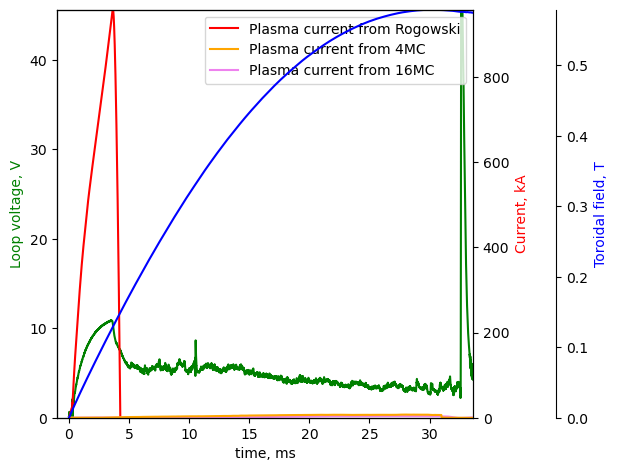

In [33]:
#%%    Programm    

vacuum_shot = 49072
shot = 49071

I_pl = plasma_current(shot, vacuum_shot)
U_loop = correct_signal('U_loop', shot, vacuum_shot)
B_t = correct_signal('B_t', shot, vacuum_shot)
t_0, t_1 = discharge_duration(I_pl, U_loop)
I_pl = calib_slope(I_pl, (t_0-1.0, t_0-0.5), (t_1+10.0, t_1+10.5))

#MC4L = MC_array('MC_lim', shot, vacuum_shot)
#MC16_array = MC_array('MC16', shot, vacuum_shot)

#Δz, Δr, r_pl = plasma_position('MC_lim', MC4L)
#Δz1, Δr1, r_pl1 = plasma_position('MC16', MC16_array)
#I_pl_MC = current_MC16(MC16_array)
#I_pl_MC2 = current_MC4(MC4L)
#q = edge_safety_factor(Δz, Δr, r_pl, I_pl, B_t, t_0, t_1)
#L_BIAS, rho_BIAS = distance_between(r_0 - z_BIAS, R_0, Δz, R_0 + Δr, r_pl)
#L_DRP, rho_DRP = distance_between(-r_0 + z_DRP, R_0, Δz, R_0 + Δr, r_pl)

#plot_distance_between(rho_BIAS, 'rho')
#plot_distance_between(rho_DRP, 'rho')
#fig1 = plot_distance_between(L_BIAS, 'distance')
#fig2 = plot_distance_between(L_DRP, 'distance')

plot_VCT()
#plot_position(Δz, Δr, r_pl)
#plot_position(Δz1, Δr1, r_pl1)
# plot_q()
# plot_chronogram()


#fig2, graph_axes = plt.subplots(figsize=(8, 8))
#fig2.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.2)
#axes_slider_time = plt.axes([0.15, 0.05, 0.75, 0.04])
#slider_time = Slider(axes_slider_time, label='time, ms', valmin=t_0, valmax=t_1, 
#                          valinit=t_0, valfmt='%1.2f', valstep=0.05)
#picture = Golem_geometry('MC16')
#slider_time.on_changed(onChangeValue)
#
#
plt.show()



# f, Cxy = sc.signal.coherence(MC16_array[1], MC16_array[2], fs=1E3)
# plt.plot(f, np.abs(Cxy))
# f, t, Sxx = sc.signal.spectrogram(MC16_array[1], fs=1E3)
# plt.pcolormesh(t, f, np.log(Sxx), shading='gouraud')

In [25]:
def analyze_shot(
    shot,
    vacuum_shot=49021,
    plot_bias_distance=True,
    plot_lp_distance=True,
    plot_drp_distance=True,
    plot_vct=False,
    plot_position_mc4=False,
    plot_position_mc16=False,
    plot_q_flag=False,
    plot_chronogram_flag=False,
    z_DRP_val=2.5,
    z_BIAS_val=1.0,
    z_lp_up_val=7.0,
    z_lp_dn_val=7.0,
    make_animation=False,
    animation_filename=None,
    save_folder=None
):
        # Update global z_DRP and z_BIAS if needed
    global z_DRP, z_BIAS
    z_DRP = z_DRP_val
    z_BIAS = z_BIAS_val
    z_LP_UP = z_lp_up_val
    z_LP_DOWN = z_lp_dn_val

    # Create save_folder if needed
    if save_folder is not None:
        os.makedirs(save_folder, exist_ok=True)

    # Calculate main signals
    I_pl = plasma_current(shot, vacuum_shot)
    U_loop = correct_signal('U_loop', shot, vacuum_shot)
    B_t = correct_signal('B_t', shot, vacuum_shot)
    t_0, t_1 = discharge_duration(I_pl, U_loop)
    I_pl = calib_slope(I_pl, (t_0-1.0, t_0-0.5), (t_1+10.0, t_1+10.5))

    MC4L = MC_array('MC_lim', shot, vacuum_shot)
    MC16_array = MC_array('MC16', shot, vacuum_shot)

    Δz, Δr, r_pl = plasma_position('MC_lim', MC4L)
    #Δz, Δr, r_pl = plasma_position('MC16', MC16_array)

    I_pl_MC = current_MC16(MC16_array)
    I_pl_MC2 = current_MC4(MC4L)
    q = edge_safety_factor(Δz, Δr, r_pl, I_pl, B_t, t_0, t_1)
    
    # L_BIAS, rho_BIAS = distance_between(r_0 - z_BIAS, R_0, Δz, R_0 + Δr, r_pl)
    # L_DRP, rho_DRP = distance_between(-r_0 + z_DRP, R_0, Δz, R_0 + Δr, r_pl)
    # L_LP_UP, rho_LP_UP = distance_between(-r_0 + z_DRP, R_0, Δz, R_0 + Δr, r_pl)
    # L_LP_DOWN, rho_LP_DOWN = distance_between(-r_0 + z_LP_DOWN, R_0, Δz, R_0 + Δr, r_pl)

    L_BIAS, rho_BIAS = distance_between(z_BIAS, R_0, Δz, R_0 + Δr, r_pl)
    L_DRP, rho_DRP = distance_between(z_DRP, R_0, Δz, R_0 + Δr, r_pl)
    L_LP_UP, rho_LP_UP = distance_between(z_LP_UP, R_0, Δz, R_0 + Δr, r_pl)
    L_LP_DOWN, rho_LP_DOWN = distance_between(z_LP_DOWN, R_0, Δz, R_0 + Δr, r_pl)

    # Helper to save or show plot
    def save_or_show(fig, name):
        if save_folder is not None:
            fig.savefig(os.path.join(save_folder, name + '.jpg'), dpi=200, bbox_inches='tight')
            plt.close(fig)
        else:
            plt.show()

    # Plotting as per flags

    if plot_bias_distance:
        # fig = plot_distance_between(L_BIAS, 'distance')
        fig = plot_distance_between(rho_BIAS, 'rho')
        #label of fig
        fig.suptitle(f'Shot #{shot} BIAS Distance', fontsize=16)
        #fig = show_start_end_dis(fig)
        save_or_show(fig, f'shot_{shot}_bias_distance')
    if plot_lp_distance:
        #upper
        # fig = plot_distance_between(L_LP_UP, 'distance')
        fig = plot_distance_between(rho_LP_UP, 'rho')
        #label of fig
        fig.suptitle(f'Shot #{shot} Langmuir probe (upper) Distance', fontsize=16)
        #fig = show_start_end_dis(fig)
        save_or_show(fig, f'shot_{shot}_lp_up_distance')

        #fig = plot_distance_between(L_LP_DOWN, 'distance')
        fig = plot_distance_between(rho_LP_DOWN, 'rho')
        #label of fig
        fig.suptitle(f'Shot #{shot} Langmuir probe (down) Distance', fontsize=16)
        #fig = show_start_end_dis(fig)
        save_or_show(fig, f'shot_{shot}_lp_down_distance')

    if plot_drp_distance:
        #fig = plot_distance_between(L_DRP, 'distance')
        fig = plot_distance_between(rho_DRP, 'rho')
        #label of fig
        fig.suptitle(f'Shot #{shot} DRP Distance', fontsize=16)
        #fig = show_start_end_dis(fig)
        save_or_show(fig, f'shot_{shot}_drp_distance')
    if plot_vct:
        fig = plot_VCT_new()
        #label of fig
        fig.suptitle(f'Shot #{shot} VCT', fontsize=16)
        fig = show_start_end_dis(fig)
        save_or_show(fig, f'shot_{shot}_VCT')
    if plot_position_mc4:
        fig = plot_position(Δz, Δr, r_pl)
        #label of fig
        fig.suptitle(f'Shot #{shot} Plasma Position (MC4)', fontsize=16)
        #fig = show_start_end_dis(fig)
        save_or_show(fig, f'shot_{shot}_position_mc4')
    if plot_position_mc16:
        fig = plot_position(Δz1, Δr1, r_pl1)
        #label of fig
        fig.suptitle(f'Shot #{shot} Plasma Position (MC16)', fontsize=16)
        #fig = show_start_end_dis(fig)
        save_or_show(fig, f'shot_{shot}_position_mc16')
    if plot_q_flag:
        fig = plot_q()
        #label of fig
        fig.suptitle(f'Shot #{shot} Safety Factor', fontsize=16)
        #fig = show_start_end_dis(fig)
        save_or_show(fig, f'shot_{shot}_q')
    if plot_chronogram_flag:
        fig = plot_chronogram()
        #label of fig
        fig.suptitle(f'Shot #{shot} Chronogram', fontsize=16)
        save_or_show(fig, f'shot_{shot}_chronogram')

    # Animation
    # import matplotlib.animation as animation
    
    n_frames = 20  # Fixed number of frames for animation
    fps = 0.5
    timestamps = r_pl[0]
    t_anim = np.linspace(timestamps[0], timestamps[-1], n_frames)

    def animate(i):
        t = t_anim[i]
        idx = np.searchsorted(timestamps, t)
        if idx >= len(timestamps):
            idx = len(timestamps) - 1
        circ1_center = (R_0 + Δr[1, idx], Δz[1, idx])
        circ1_radius = r_pl[1, idx]
        graph_axes.clear()
        #Golem_geometry_mp4(graph_axes, 'MC16', shot, time = t)
        Golem_geometry_mp4(graph_axes, 'MC4', shot, time = t)
        circ1 = patch.Circle(circ1_center, circ1_radius, color='r')
        graph_axes.add_patch(circ1)
        return []

    if make_animation==True:
        fig2, graph_axes = plt.subplots(figsize=(8, 8))

        if animation_filename is None:
            animation_filename = f"shot_{shot}_cords_animation"
        if save_folder is not None:
            animation_filename = os.path.join(save_folder, animation_filename)
        ani = animation.FuncAnimation(
            fig2, animate, frames=n_frames, interval=n_frames/fps, blit=False
        )
        try:
            Writer = animation.writers['ffmpeg']
            mp4_filename = animation_filename + ".mp4"
            ani.save(mp4_filename, writer=Writer(fps=fps))
        except (KeyError, FileNotFoundError, ValueError, RuntimeError):
            gif_filename = animation_filename + ".gif"
            ani.save(gif_filename, writer='pillow', fps=fps)
            print(f"ffmpeg unavailable, saved animation as {gif_filename}")
        plt.close(fig2)
    #elif save_folder is None:
    #    plt.show()

C:\Users\danil\AppData\Local\Temp\ipykernel_21120\3611109947.py:22: RuntimeWarning: invalid value encountered in divide
  Δz   =  r_MC*(B_5[1]-B_13[1])/(B_5[1]+B_13[1])     # cm
C:\Users\danil\AppData\Local\Temp\ipykernel_21120\3611109947.py:23: RuntimeWarning: invalid value encountered in divide
  Δr   =  r_MC*(B_1[1]-B_9[1])/(B_1[1]+B_9[1])       # cm


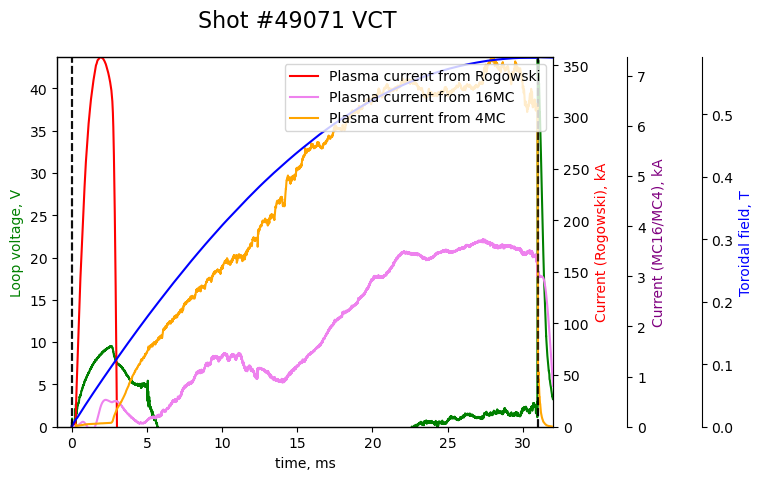

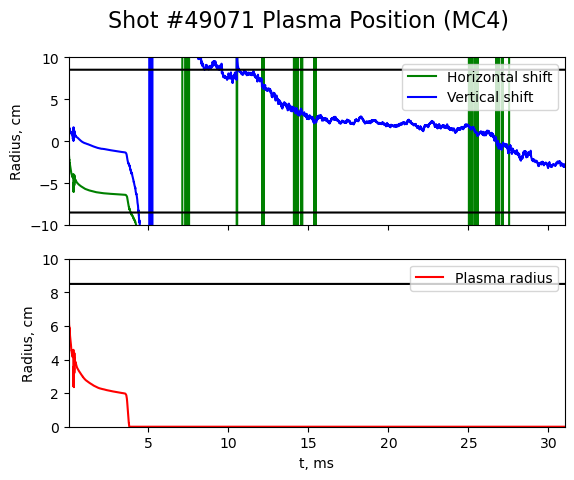

In [30]:
analyze_shot(
    shot=49071,
    vacuum_shot=49072,
    plot_bias_distance=False,
    plot_lp_distance = False,
    plot_drp_distance=False,
    plot_vct=True,
    plot_position_mc4=True,
    plot_position_mc16=False,
    plot_q_flag=False,
    plot_chronogram_flag=False,
    z_DRP_val=-5.5,
    z_BIAS_val=7.0,
    z_lp_up_val=7.0,
    z_lp_dn_val=-6.0,
    make_animation=True,
    save_folder = None
    #animation_filename="plasma_animation"
)

In [ ]:
# Batch analyze_shot for a range of shots and z_DRP values
#shots = range(49029, 49040)
#z_DRP_values = np.arange(8, 4.5, -0.5)
shots = range(49029, 49040)
#z_DRP_values = np.arange(8, 5.4, -0.5)
z_DRP_values =  [-8.0, -7.5, -7.0, -6.5, -6.0, -6.0, -6.0, -5.5, -5.5, -5.5, -5.5] #from the center 
z_lp_dn_values= [-8.5, -8.0, -7.5, -7.0, -6.5, -6.5, -6.5, -6.0, -6.0, -6.0, -6.0]
z_bias = 7.0  # Fixed value for BIAS distance
z_lp_up = 7.0  # Fixed value for LP (= BIAS) upper distance

for shot, z_DRP, z_lp_down in zip(shots, z_DRP_values, z_lp_dn_values):
    out_folder = f"./processed/{shot}_out/"
    analyze_shot(
        shot=shot,
        vacuum_shot=49021,
        plot_bias_distance=True,
        plot_lp_distance=True,
        plot_drp_distance=True,
        plot_vct=True,
        plot_position_mc4=True,
        plot_position_mc16=False,
        plot_q_flag=False,
        plot_chronogram_flag=False,
        z_lp_dn_val= z_lp_down,
        z_lp_up_val= z_lp_up,
        z_DRP_val=z_DRP,
        z_BIAS_val= z_bias,
        make_animation=True,
        save_folder=out_folder
    )

KeyboardInterrupt: 

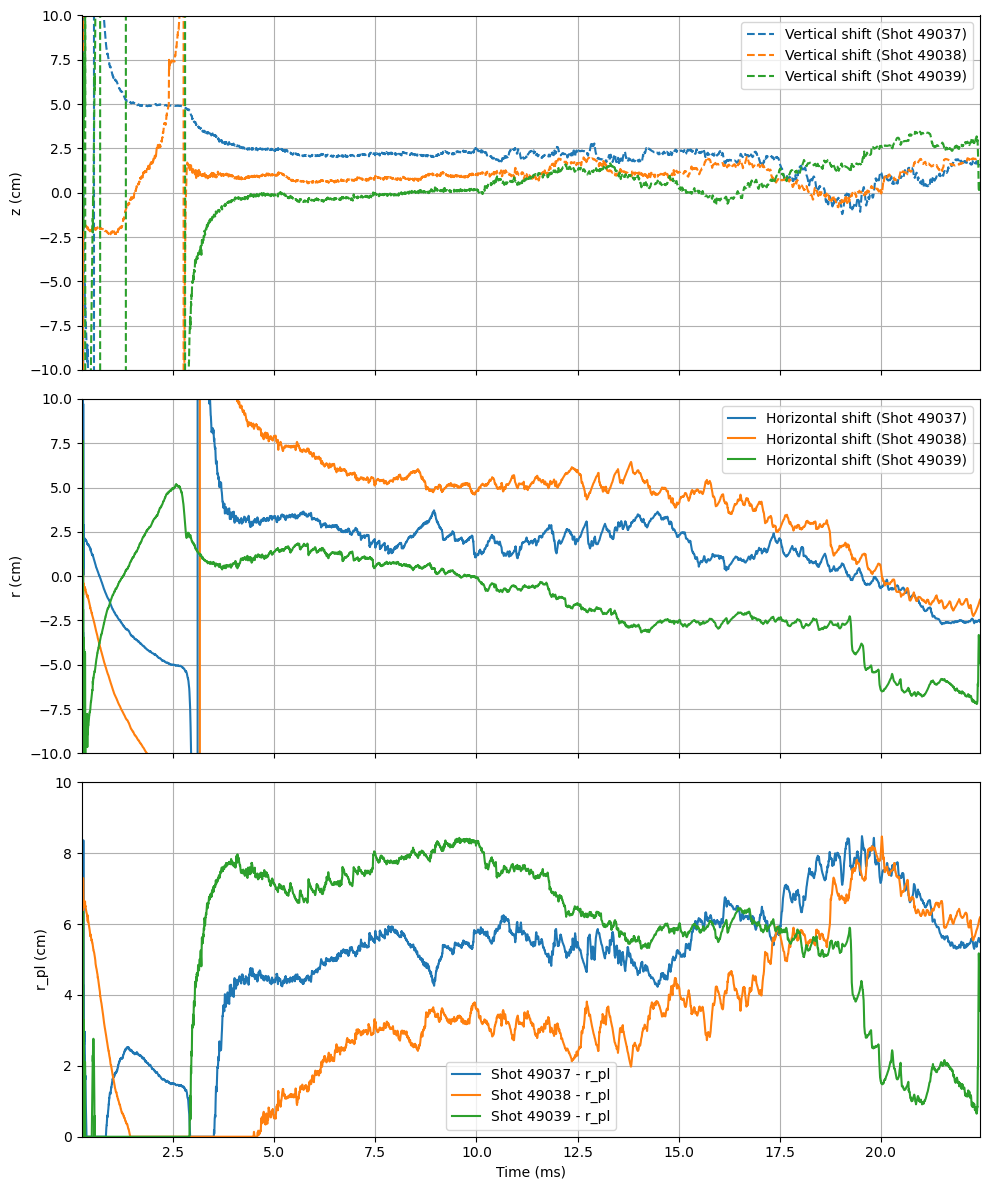

In [ ]:
#%%    Programm    

vacuum_shot = 49021
shots = (49037, 49038, 49039)

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for shot in shots:

    I_pl = plasma_current(shot, vacuum_shot)
    U_loop = correct_signal('U_loop', shot, vacuum_shot)
    B_t = correct_signal('B_t', shot, vacuum_shot)
    t_0, t_1 = discharge_duration(I_pl, U_loop)
    I_pl = calib_slope(I_pl, (t_0-1.0, t_0-0.5), (t_1+10.0, t_1+10.5))

    MC4L = MC_array('MC_lim', shot, vacuum_shot)
    #MC16_array = MC_array('MC16', shot, vacuum_shot)
    Δz, Δr, r_pl = plasma_position('MC_lim', MC4L)

    ax[0].plot(Δz[0], Δz[1], label=f'Vertical shift (Shot {shot})', linestyle='--')
    ax[1].plot(Δr[0], Δr[1], label=f'Horizontal shift (Shot {shot})')

    ax[0].set_ylabel('z (cm)')
    ax[1].set_ylabel('r (cm)')

    # Plot r_pl for each shot
    ax[2].plot(r_pl[0], r_pl[1], label=f'Shot {shot} - r_pl')

    ax[2].set_xlabel('Time (ms)')
    ax[2].set_ylabel('r_pl (cm)')

for i in range(2):
    ax[i].legend()
    ax[i].set_ylim(-r_0, r_0)
    ax[i].grid(True)
    ax[i].set_xlim(t_0, t_1)

ax[2].legend()
ax[2].set_ylim(0, r_0)
ax[2].grid(True)
ax[2].set_xlim(t_0, t_1)

plt.tight_layout()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt

def plot_z_r_rpl(Δz_list, Δr_list, r_pl_list, shots):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot z and r for each shot
    for i, shot in enumerate(shots):
        ax1.plot(Δz_list[i][0], Δz_list[i][1], label=f'Shot {shot} - z', linestyle='--')
        ax1.plot(Δr_list[i][0], Δr_list[i][1], label=f'Shot {shot} - r')

    ax1.set_ylabel('z, r (cm)')
    ax1.legend()
    ax1.grid(True)

    # Plot r_pl for each shot
    for i, shot in enumerate(shots):
        ax2.plot(r_pl_list[i][0], r_pl_list[i][1], label=f'Shot {shot} - r_pl')

    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('r_pl (cm)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
# plot_z_r_rpl(Δz_list, Δr_list, r_pl_list, shots)